In [1]:
import torch
import datasets, networks, sampling, completion, evaluation
import matplotlib.pyplot as plt
from torch import nn

In [2]:
#HYPERPARAMETERS
num_epochs = 9

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adam'

# TODO Select a lr scheduler. [ 'step', 'cosine', 'exponential']
lr_scheduler_option = ''

# TODO Select a batch size.
batch_size = 16

# TODO Select a learning rate.
lr = 0.0001


num_residual = 10
num_kernels = 64

In [3]:
ds = datasets.Dataset('cifar10', batch_size=batch_size)
training_data = ds.get_train_data_loader()
test_data = ds.get_test_data_loader()

# ds.visualize_dataset(training_data)

100.0%


Extracting data\cifar-10-python.tar.gz to data


Using device: cuda:0
Epoch:   1/  9, Batch     1, Loss: 5.5479
Epoch:   1/  9, Batch   101, Loss: 5.5070
Epoch:   1/  9, Batch   201, Loss: 5.1127
Epoch:   1/  9, Batch   301, Loss: 4.7684
Epoch:   1/  9, Batch   401, Loss: 4.6418
Epoch:   1/  9, Batch   501, Loss: 4.5703
Epoch:   1/  9, Batch   601, Loss: 4.5349
Epoch:   1/  9, Batch   701, Loss: 4.5233
Epoch:   1/  9, Batch   801, Loss: 4.4802
Epoch:   1/  9, Batch   901, Loss: 4.4605
Epoch:   1/  9, Batch  1001, Loss: 4.4554
Epoch:   1/  9, Batch  1101, Loss: 4.4468
Epoch:   1/  9, Batch  1201, Loss: 4.4411
Epoch:   1/  9, Batch  1301, Loss: 4.4319
Epoch:   1/  9, Batch  1401, Loss: 4.4129
Epoch:   1/  9, Batch  1501, Loss: 4.4059
Epoch:   1/  9, Batch  1601, Loss: 4.4348
Epoch:   1/  9, Batch  1701, Loss: 4.4086
Epoch:   1/  9, Batch  1801, Loss: 4.4068
Epoch:   1/  9, Batch  1901, Loss: 4.3978
Epoch:   1/  9, Batch  2001, Loss: 4.3802
Epoch:   1/  9, Batch  2101, Loss: 4.3827
Epoch:   1/  9, Batch  2201, Loss: 4.3823
Epoch:   1/  

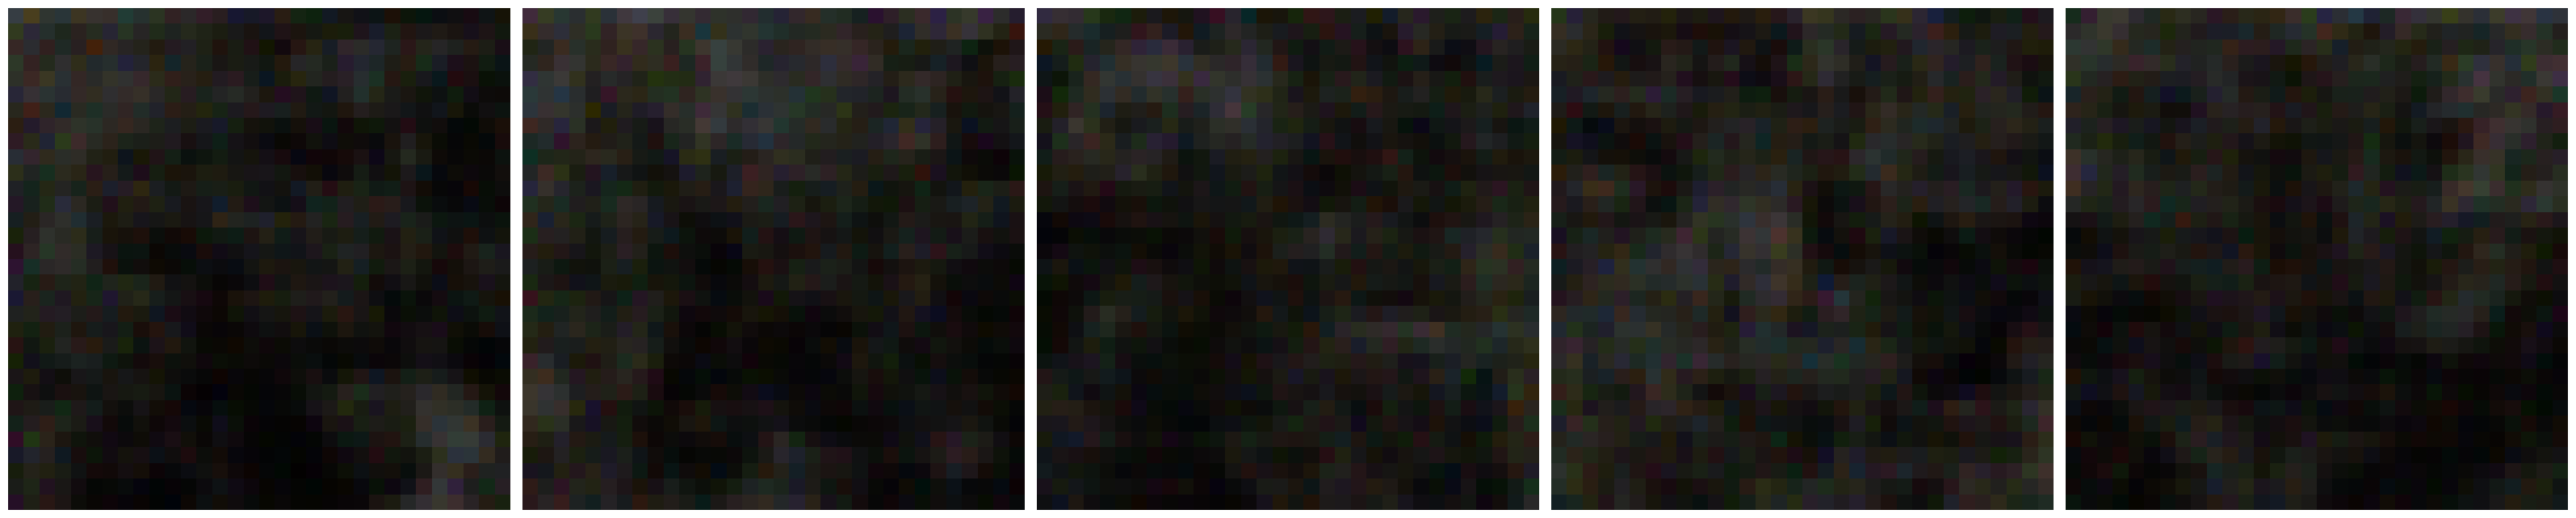

Epoch:   2/  9, Batch     1, Loss: 4.4412
Epoch:   2/  9, Batch   101, Loss: 4.3522
Epoch:   2/  9, Batch   201, Loss: 4.3489
Epoch:   2/  9, Batch   301, Loss: 4.3299
Epoch:   2/  9, Batch   401, Loss: 4.3163
Epoch:   2/  9, Batch   501, Loss: 4.3240
Epoch:   2/  9, Batch   601, Loss: 4.3087
Epoch:   2/  9, Batch   701, Loss: 4.2922
Epoch:   2/  9, Batch   801, Loss: 4.3151
Epoch:   2/  9, Batch   901, Loss: 4.3184
Epoch:   2/  9, Batch  1001, Loss: 4.3116
Epoch:   2/  9, Batch  1101, Loss: 4.3000
Epoch:   2/  9, Batch  1201, Loss: 4.2855
Epoch:   2/  9, Batch  1301, Loss: 4.2863
Epoch:   2/  9, Batch  1401, Loss: 4.2951
Epoch:   2/  9, Batch  1501, Loss: 4.2754
Epoch:   2/  9, Batch  1601, Loss: 4.2761
Epoch:   2/  9, Batch  1701, Loss: 4.2974
Epoch:   2/  9, Batch  1801, Loss: 4.2780
Epoch:   2/  9, Batch  1901, Loss: 4.2954
Epoch:   2/  9, Batch  2001, Loss: 4.2638
Epoch:   2/  9, Batch  2101, Loss: 4.2777
Epoch:   2/  9, Batch  2201, Loss: 4.2574
Epoch:   2/  9, Batch  2301, Loss:

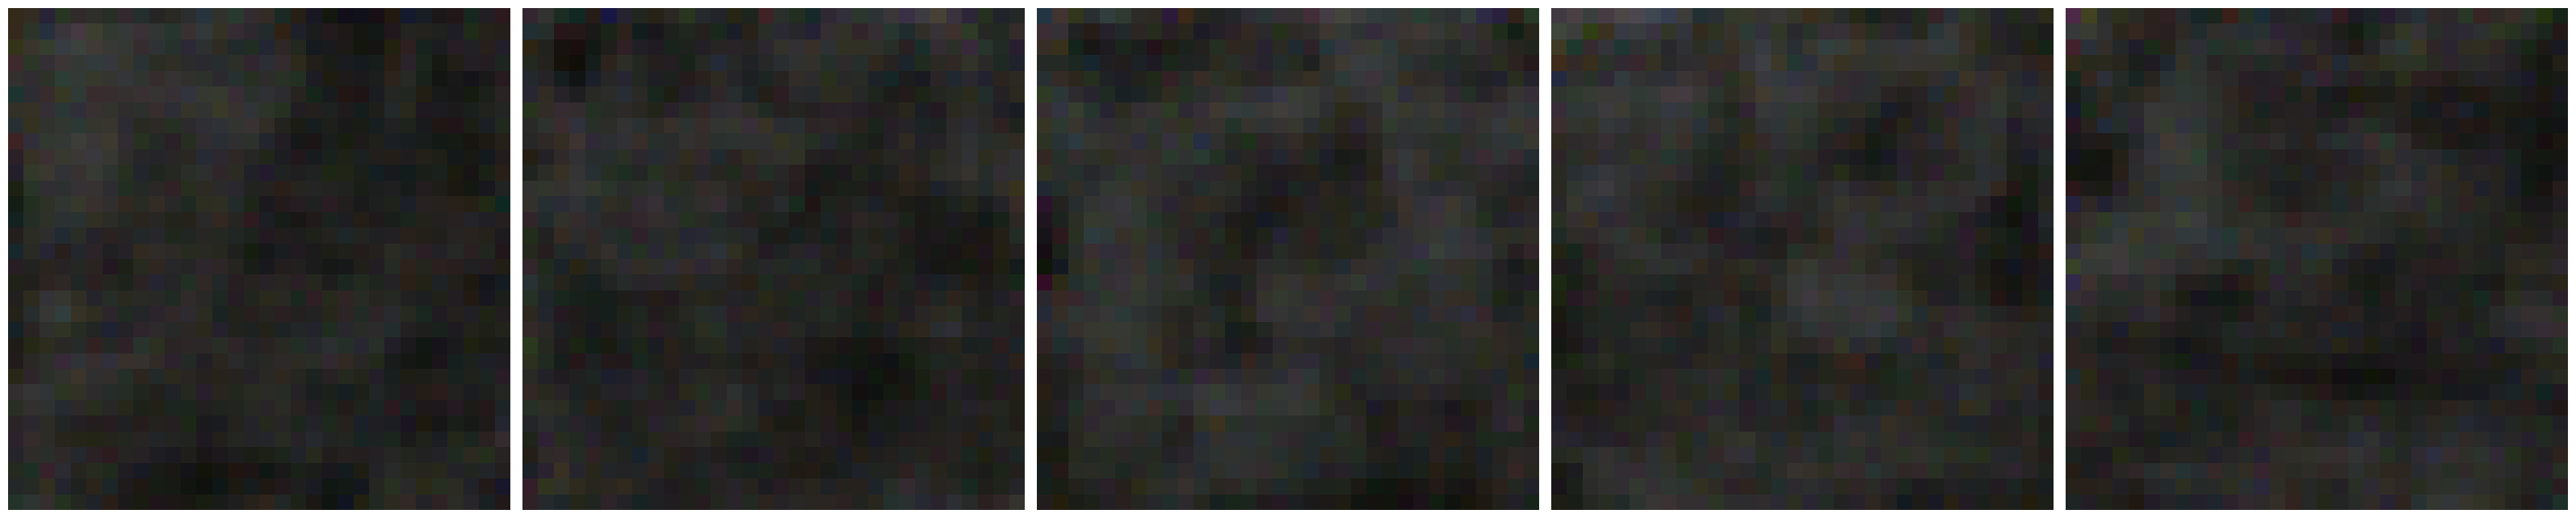

Epoch:   3/  9, Batch     1, Loss: 4.2283
Epoch:   3/  9, Batch   101, Loss: 4.2170
Epoch:   3/  9, Batch   201, Loss: 4.2199
Epoch:   3/  9, Batch   301, Loss: 4.1857
Epoch:   3/  9, Batch   401, Loss: 4.1789
Epoch:   3/  9, Batch   501, Loss: 4.1730
Epoch:   3/  9, Batch   601, Loss: 4.1665
Epoch:   3/  9, Batch   701, Loss: 4.1569
Epoch:   3/  9, Batch   801, Loss: 4.1464
Epoch:   3/  9, Batch   901, Loss: 4.1348
Epoch:   3/  9, Batch  1001, Loss: 4.1237
Epoch:   3/  9, Batch  1101, Loss: 4.1329
Epoch:   3/  9, Batch  1201, Loss: 4.0978
Epoch:   3/  9, Batch  1301, Loss: 4.1028
Epoch:   3/  9, Batch  1401, Loss: 4.1165
Epoch:   3/  9, Batch  1501, Loss: 4.0963
Epoch:   3/  9, Batch  1601, Loss: 4.0815
Epoch:   3/  9, Batch  1701, Loss: 4.0901
Epoch:   3/  9, Batch  1801, Loss: 4.0754
Epoch:   3/  9, Batch  1901, Loss: 4.0556
Epoch:   3/  9, Batch  2001, Loss: 4.0644
Epoch:   3/  9, Batch  2101, Loss: 4.0631
Epoch:   3/  9, Batch  2201, Loss: 4.0493
Epoch:   3/  9, Batch  2301, Loss:

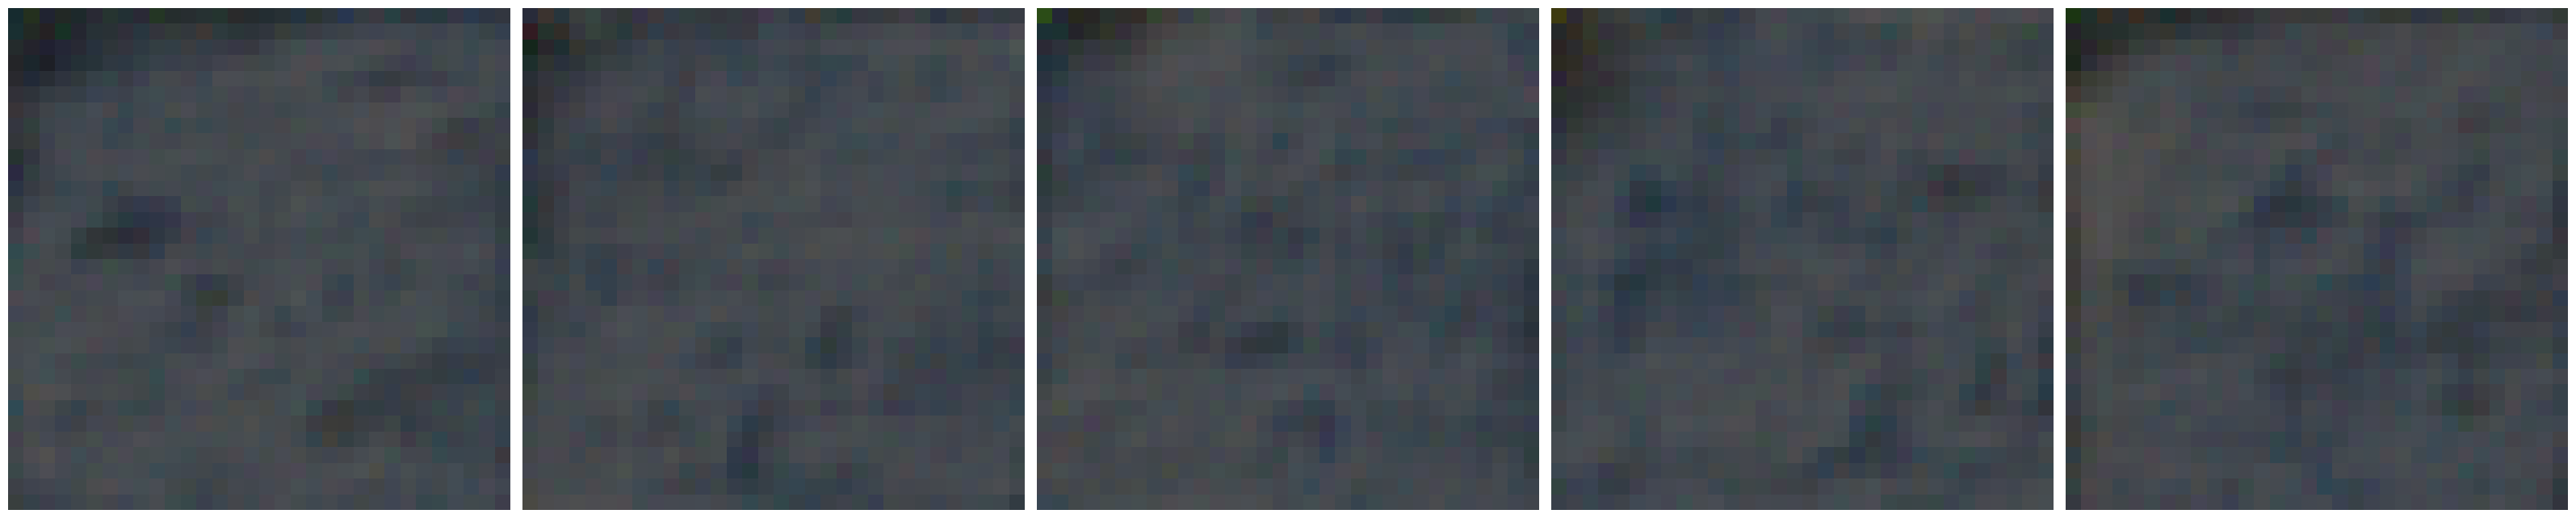

Epoch:   4/  9, Batch     1, Loss: 3.8884
Epoch:   4/  9, Batch   101, Loss: 4.0152
Epoch:   4/  9, Batch   201, Loss: 3.9786
Epoch:   4/  9, Batch   301, Loss: 3.9707
Epoch:   4/  9, Batch   401, Loss: 3.9790
Epoch:   4/  9, Batch   501, Loss: 3.9998
Epoch:   4/  9, Batch   601, Loss: 3.9720
Epoch:   4/  9, Batch   701, Loss: 3.9802
Epoch:   4/  9, Batch   801, Loss: 3.9632
Epoch:   4/  9, Batch   901, Loss: 3.9652
Epoch:   4/  9, Batch  1001, Loss: 3.9673
Epoch:   4/  9, Batch  1101, Loss: 3.9650
Epoch:   4/  9, Batch  1201, Loss: 3.9545
Epoch:   4/  9, Batch  1301, Loss: 3.9484
Epoch:   4/  9, Batch  1401, Loss: 3.9595
Epoch:   4/  9, Batch  1501, Loss: 3.9615
Epoch:   4/  9, Batch  1601, Loss: 3.9556
Epoch:   4/  9, Batch  1701, Loss: 3.9491
Epoch:   4/  9, Batch  1801, Loss: 3.9592
Epoch:   4/  9, Batch  1901, Loss: 3.9443
Epoch:   4/  9, Batch  2001, Loss: 3.9240
Epoch:   4/  9, Batch  2101, Loss: 3.9285
Epoch:   4/  9, Batch  2201, Loss: 3.9127
Epoch:   4/  9, Batch  2301, Loss:

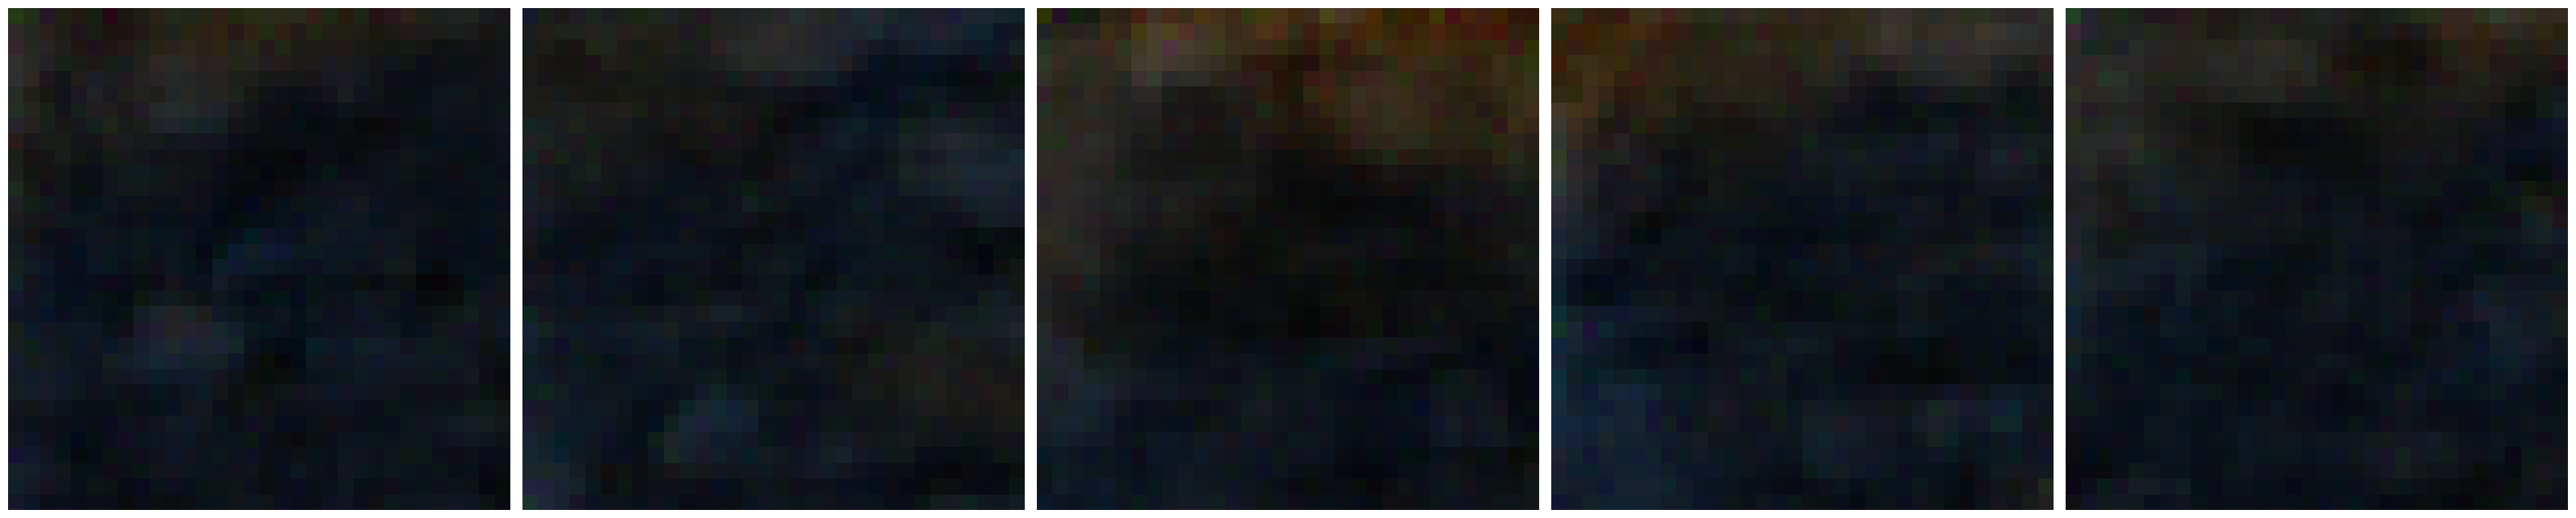

Epoch:   5/  9, Batch     1, Loss: 3.8832
Epoch:   5/  9, Batch   101, Loss: 3.9102
Epoch:   5/  9, Batch   201, Loss: 3.9117
Epoch:   5/  9, Batch   301, Loss: 3.9150
Epoch:   5/  9, Batch   401, Loss: 3.9038
Epoch:   5/  9, Batch   501, Loss: 3.8859
Epoch:   5/  9, Batch   601, Loss: 3.9238
Epoch:   5/  9, Batch   701, Loss: 3.8942
Epoch:   5/  9, Batch   801, Loss: 3.9008
Epoch:   5/  9, Batch   901, Loss: 3.9353
Epoch:   5/  9, Batch  1001, Loss: 3.8949
Epoch:   5/  9, Batch  1101, Loss: 3.9161
Epoch:   5/  9, Batch  1201, Loss: 3.8964
Epoch:   5/  9, Batch  1301, Loss: 3.8964
Epoch:   5/  9, Batch  1401, Loss: 3.8746
Epoch:   5/  9, Batch  1501, Loss: 3.8931
Epoch:   5/  9, Batch  1601, Loss: 3.8708
Epoch:   5/  9, Batch  1701, Loss: 3.8777
Epoch:   5/  9, Batch  1801, Loss: 3.8881
Epoch:   5/  9, Batch  1901, Loss: 3.8822
Epoch:   5/  9, Batch  2001, Loss: 3.8992
Epoch:   5/  9, Batch  2101, Loss: 3.8842
Epoch:   5/  9, Batch  2201, Loss: 3.8851
Epoch:   5/  9, Batch  2301, Loss:

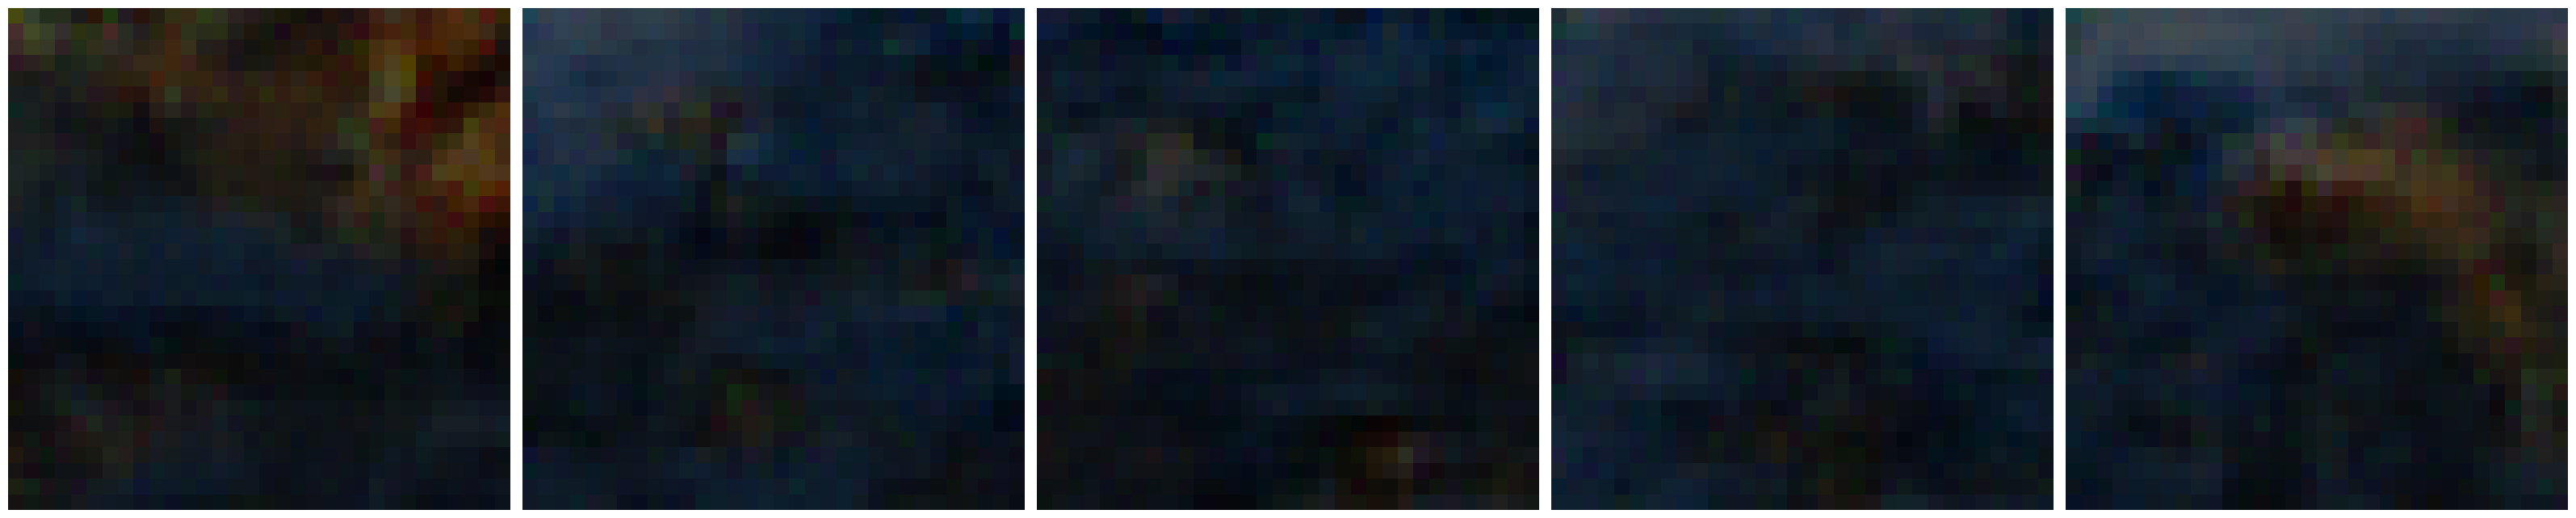

Epoch:   6/  9, Batch     1, Loss: 3.9315
Epoch:   6/  9, Batch   101, Loss: 3.8700
Epoch:   6/  9, Batch   201, Loss: 3.8729
Epoch:   6/  9, Batch   301, Loss: 3.8677
Epoch:   6/  9, Batch   401, Loss: 3.8515
Epoch:   6/  9, Batch   501, Loss: 3.8641
Epoch:   6/  9, Batch   601, Loss: 3.8568
Epoch:   6/  9, Batch   701, Loss: 3.8572
Epoch:   6/  9, Batch   801, Loss: 3.8504
Epoch:   6/  9, Batch   901, Loss: 3.8462
Epoch:   6/  9, Batch  1001, Loss: 3.8643
Epoch:   6/  9, Batch  1101, Loss: 3.8722
Epoch:   6/  9, Batch  1201, Loss: 3.8556
Epoch:   6/  9, Batch  1301, Loss: 3.8671
Epoch:   6/  9, Batch  1401, Loss: 3.8633
Epoch:   6/  9, Batch  1501, Loss: 3.8434
Epoch:   6/  9, Batch  1601, Loss: 3.8597
Epoch:   6/  9, Batch  1701, Loss: 3.8877
Epoch:   6/  9, Batch  1801, Loss: 3.8674
Epoch:   6/  9, Batch  1901, Loss: 3.8377
Epoch:   6/  9, Batch  2001, Loss: 3.8560
Epoch:   6/  9, Batch  2101, Loss: 3.8437
Epoch:   6/  9, Batch  2201, Loss: 3.8651
Epoch:   6/  9, Batch  2301, Loss:

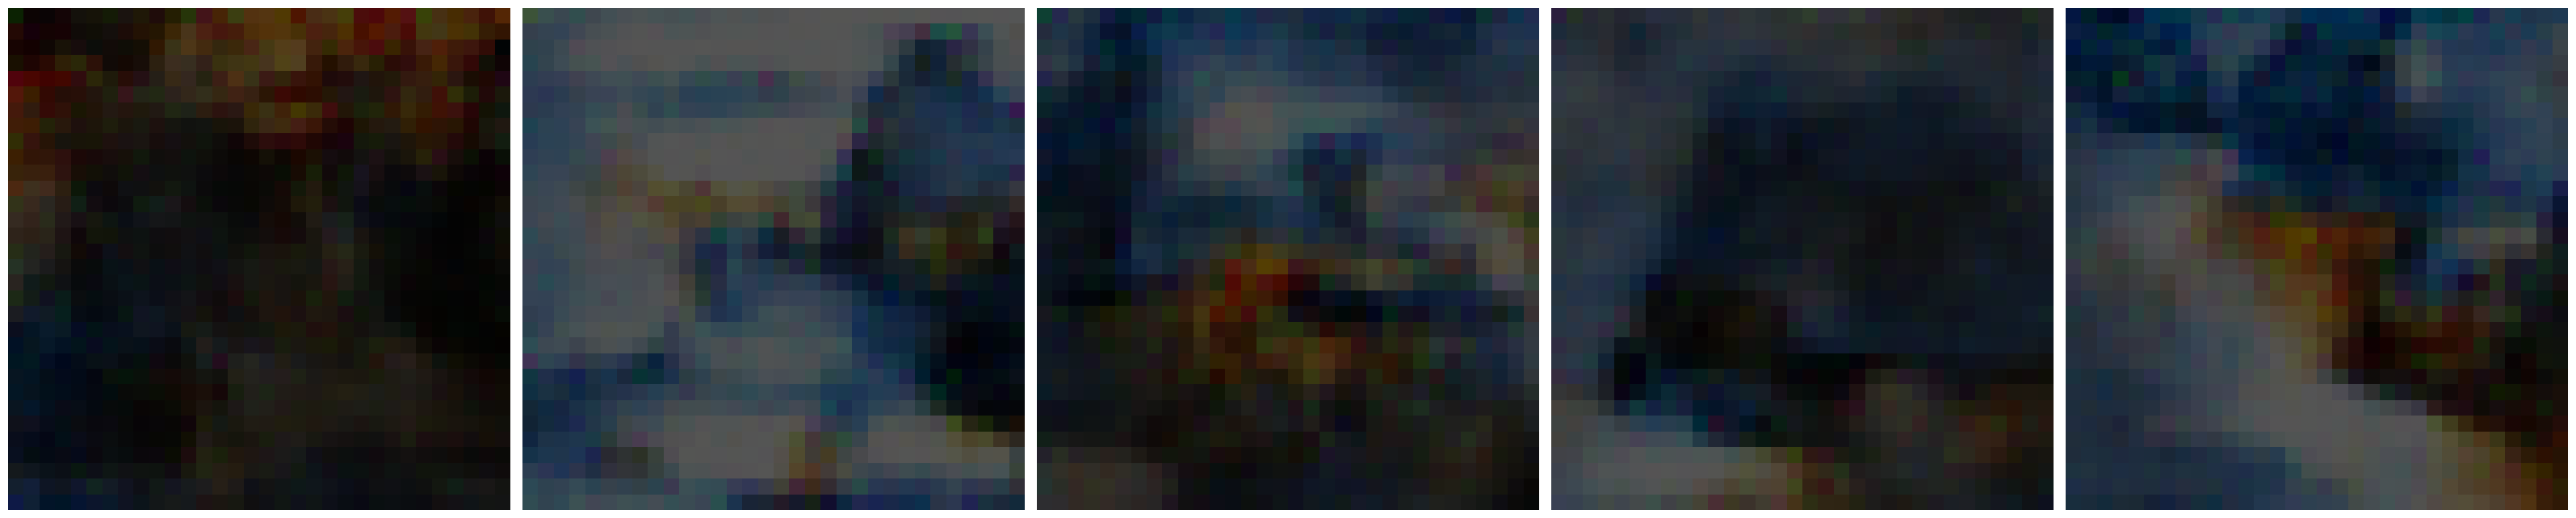

Epoch:   7/  9, Batch     1, Loss: 3.8389
Epoch:   7/  9, Batch   101, Loss: 3.8299
Epoch:   7/  9, Batch   201, Loss: 3.8324
Epoch:   7/  9, Batch   301, Loss: 3.8150
Epoch:   7/  9, Batch   401, Loss: 3.8497
Epoch:   7/  9, Batch   501, Loss: 3.8244
Epoch:   7/  9, Batch   601, Loss: 3.8547
Epoch:   7/  9, Batch   701, Loss: 3.8232
Epoch:   7/  9, Batch   801, Loss: 3.8366
Epoch:   7/  9, Batch   901, Loss: 3.8618
Epoch:   7/  9, Batch  1001, Loss: 3.8292
Epoch:   7/  9, Batch  1101, Loss: 3.8349
Epoch:   7/  9, Batch  1201, Loss: 3.8189
Epoch:   7/  9, Batch  1301, Loss: 3.8083
Epoch:   7/  9, Batch  1401, Loss: 3.8239
Epoch:   7/  9, Batch  1501, Loss: 3.8189
Epoch:   7/  9, Batch  1601, Loss: 3.8258
Epoch:   7/  9, Batch  1701, Loss: 3.8309
Epoch:   7/  9, Batch  1801, Loss: 3.8359
Epoch:   7/  9, Batch  1901, Loss: 3.8339
Epoch:   7/  9, Batch  2001, Loss: 3.8329
Epoch:   7/  9, Batch  2101, Loss: 3.8131
Epoch:   7/  9, Batch  2201, Loss: 3.8105
Epoch:   7/  9, Batch  2301, Loss:

KeyboardInterrupt: 

In [4]:
# Training
import time
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.optim import Adam, AdamW, RMSprop, SGD 

PixelCNN = networks.PixelCNN(num_kernels=num_kernels, num_residual=num_residual)
# Select device
# if torch.cuda.is_available():
#   device = torch.device('cuda:0')
# else:
#   device = torch.device('cpu')
device = torch.device('cuda:0')
print(f'Using device: {device}')
print('=========================================')

PixelCNN.to(device)

learning_rates = []
train_loss_curve = []
test_loss_curve = []
train_loss_epochs = []
test_loss_epochs = []
optimizer = None

# Select optimizer
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(PixelCNN.parameters(), lr)
  
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(PixelCNN.parameters(), lr)
  
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(PixelCNN.parameters(), lr)
  
else:
  optimizer = torch.optim.SGD(PixelCNN.parameters(), lr, momentum=0.9)  


#Select scheduler
scheduler = None
if lr_scheduler_option == 'step':
    scheduler = StepLR(optimizer, step_size=2, gamma=0.9)
    
elif lr_scheduler_option == 'exponential':
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    
elif lr_scheduler_option == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

overall_start_time = time.time()

# training loop
for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  PixelCNN.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)
    output = PixelCNN(images)
    # print(output.shape)
    images = images.view(-1)
    # images = images.permute(0, 2, 3, 1).contiguous().view(-1)
    # print(images.shape)
    output = torch.reshape(output, (batch_size, 256, 3, 32, 32))
    output = output.permute(0,2,3,4,1).contiguous().view(-1, 256)

    # output = nn.functional.softmax(output, dim=1)
    # output = torch.argmax(output, dim=1)

    # print(output)
    images = images*255
    # print(images.long())

    loss = nn.functional.cross_entropy(output, images.long())
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(PixelCNN.parameters(), 1)
    optimizer.step()
    for param_group in optimizer.param_groups:
      learning_rates.append(param_group['lr'])
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      train_loss_curve.append(average_loss)
      train_loss_epochs.append(epoch + 1)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  # scheduler.step()
  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  test_loss = evaluation.evaluate(model=PixelCNN, test_data_loader=test_data, device=device, batch_size=batch_size)
  test_loss_curve.append(test_loss)
  test_loss_epochs.append(epoch + 1)
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {test_loss:.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(PixelCNN, num_samples=5)
  sampling.save_samples(samples)
  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

# Loss Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, train_loss_curve, label='Train Loss')
plt.scatter(test_loss_epochs, test_loss_curve, color='red', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Learning Rate Plot
num_batches = len(training_data)
learning_rates_res = [sum(learning_rates[i * num_batches:(i + 1) * num_batches]) / num_batches for i in range(num_epochs)]
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates_res)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Time')
plt.show()